<a href="https://colab.research.google.com/github/Vamsi995/exsim/blob/main/Qwen_Distribution_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q accelerate safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict

In [101]:
# ✅ Colab-Ready Notebook: Functional Similarity Testing for MoE Experts (Decoder-Only)



# Load Qwen1.5-MoE decoder-only model
model_id = "Qwen/Qwen1.5-MoE-A2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16
)




Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

# Dataset

In [4]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [5]:
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from collections import defaultdict

In [6]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tok_ds = dataset["train"].map(tokenize, batched=True, remove_columns=["text"])
train_size = int(0.8 * len(tok_ds))
train_ds, val_ds = random_split(tok_ds, [train_size, len(tok_ds) - train_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict


In [8]:

# -------------------
# Adapter Definition
# -------------------
class Adapter(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(self.linear(x))

In [9]:


from collections import defaultdict
import torch

# Captures (input, output) for each expert
expert_pairs = defaultdict(list)

z2_all = []

def make_aligned_expert_hook(layer_id, expert_id):
    def hook_fn(module, input, output):
        z = input[0].detach().cpu()
        fz = output.detach().cpu()
        for i in range(z.shape[0]):
            expert_pairs[(layer_id, expert_id)].append((z[i], fz[i]))
        if layer_id == layer2:
            z2_all.append(z)
    return hook_fn



# def make_aligned_expert_hook(layer_id, expert_id):
#     def hook_fn(module, input, output):
#         z1 = input[0].detach().cpu()
#         fz1 = output.detach().cpu()
#         for i in range(z1.shape[0]):
#             expert_pairs[(layer_id, expert_id)].append((z1[i], fz1[i]))
#     return hook_fn

def get_aligned_data(layer_id, expert_id, device):
    z_list, fz_list = zip(*expert_pairs[(layer_id, expert_id)])
    z1 = torch.stack(z_list).to(device)
    fz1 = torch.stack(fz_list).to(device)
    return z1, fz1

# This captures the input before routing
layer_inputs = defaultdict(list)
def make_router_input_hook(layer_id):
    def hook_fn(module, input):
        hidden = input[0]
        if hidden.size(-1) == 2048:
            layer_inputs[layer_id].append(hidden.detach().cpu())
    return hook_fn

# Attach hooks for two experts at (layer1, expert1) and (layer2, expert2)
def attach_moe_hooks(model, pair1, pair2):
    hooks = []
    for lid in {pair1[0], pair2[0]}:
        moe_block = model.model.layers[lid].mlp
        hooks.append(moe_block.register_forward_pre_hook(make_router_input_hook(lid)))
    for (lid, eid) in [pair1, pair2]:
        expert = model.model.layers[lid].mlp.experts[eid]
        hooks.append(expert.register_forward_hook(make_aligned_expert_hook(lid, eid)))
    return hooks


# Manually run z1 through expert1 to get f1_output
def get_z1_and_f1_output(layer_id, expert_id, device):
    z1 = torch.cat(layer_inputs[layer_id], dim=0).to(device)
    expert = model.model.layers[layer_id].mlp.experts[expert_id]
    f1_output = expert(z1)
    return z1, f1_output



In [10]:
# -------------------
# Run Inference + Compare Experts
# -------------------
layer1, expert1 = 1, 1
layer2, expert2 = 2, 1
hooks = attach_moe_hooks(model, (layer1, expert1), (layer2, expert2))

In [11]:
model.eval()
samples_needed = 100
with torch.no_grad():
    for batch in train_loader:
        input_ids = torch.stack(batch['input_ids']).to('cuda')
        model(input_ids)
        if len(expert_pairs[(layer1, expert1)]) >= samples_needed:
            break
for h in hooks: h.remove()



In [12]:
z1, f1_out = get_aligned_data(layer1, expert1, model.device)
z2 = torch.cat(z2_all, dim=0).to(model.device)

# f2 = model.model.layers[layer2].mlp.experts[expert2]

In [13]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [17]:
def visualize_distribution_stats(z1, y1, z2):
    """Visualize the raw value distributions of z1, y1, and z2 using histograms."""
    plt.figure(figsize=(12, 5))

    for idx, (data, label) in enumerate(zip([z1, y1, z2], ['z1 (L1 - PreRouter Inputs)', 'y1 (L1 Outputs)', 'z2 (L2 - PreRouter Inputs))'])):
        plt.subplot(1, 3, idx+1)
        flattened = data.detach().cpu().numpy().flatten()
        plt.hist(flattened, bins=100, alpha=0.7, color='C' + str(idx))
        plt.title(f"{label}\nMean: {flattened.mean():.4f}")
        plt.grid(True)

    plt.suptitle("Distribution of Activation Values")
    plt.tight_layout()
    plt.show()


In [18]:
def visualize_pca_distributions(z1, y1, z2):
    pca = PCA(n_components=3)
    all_data = torch.cat([z1, y1, z2], dim=0).cpu().numpy()
    reduced = pca.fit_transform(all_data)
    n = z1.size(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:n, 0], reduced[:n, 1], label="z1 (Input Layer 1)", alpha=0.5)
    plt.scatter(reduced[n:2*n, 0], reduced[n:2*n, 1], label="y1 (Output Layer 1)", alpha=0.5)
    plt.scatter(reduced[2*n:, 0], reduced[2*n:, 1], label="z2 (Input Layer 2)", alpha=0.5)
    plt.legend()
    plt.title("PCA of z1, y1, z2")
    plt.grid(True)
    plt.show()


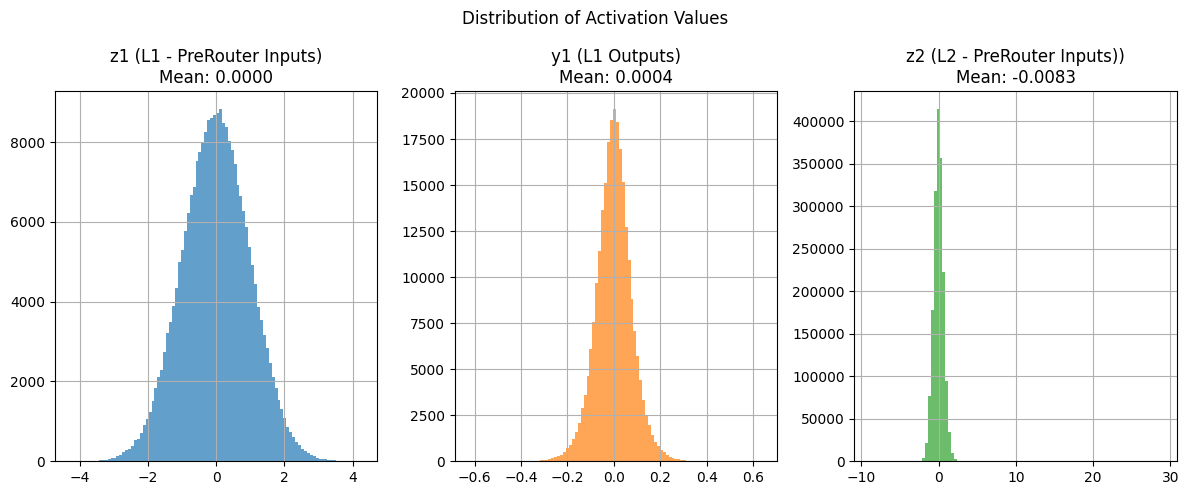

In [64]:
visualize_distribution_stats(a_yi, f1_out, z2)

In [28]:
visualize_pca_distributions(z1, f1_out, z2)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [21]:
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

def visualize_pca_distributions(z1, y1, z2):
    pca = PCA(n_components=3)
    all_data = torch.cat([z1, y1, z2], dim=0).cpu().numpy()
    reduced = pca.fit_transform(all_data)
    n = z1.size(0)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(reduced[:n, 0], reduced[:n, 1], reduced[:n, 2], label="z1 (Input Layer 1)", alpha=0.5)
    ax.scatter(reduced[n:2*n, 0], reduced[n:2*n, 1], reduced[n:2*n, 2], label="y1 (Output Layer 1)", alpha=0.5)
    ax.scatter(reduced[2*n:, 0], reduced[2*n:, 1], reduced[2*n:, 2], label="z2 (Input Layer 2)", alpha=0.5)

    ax.set_title("3D PCA of z1, y1, z2")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.legend()
    plt.tight_layout()
    plt.show()


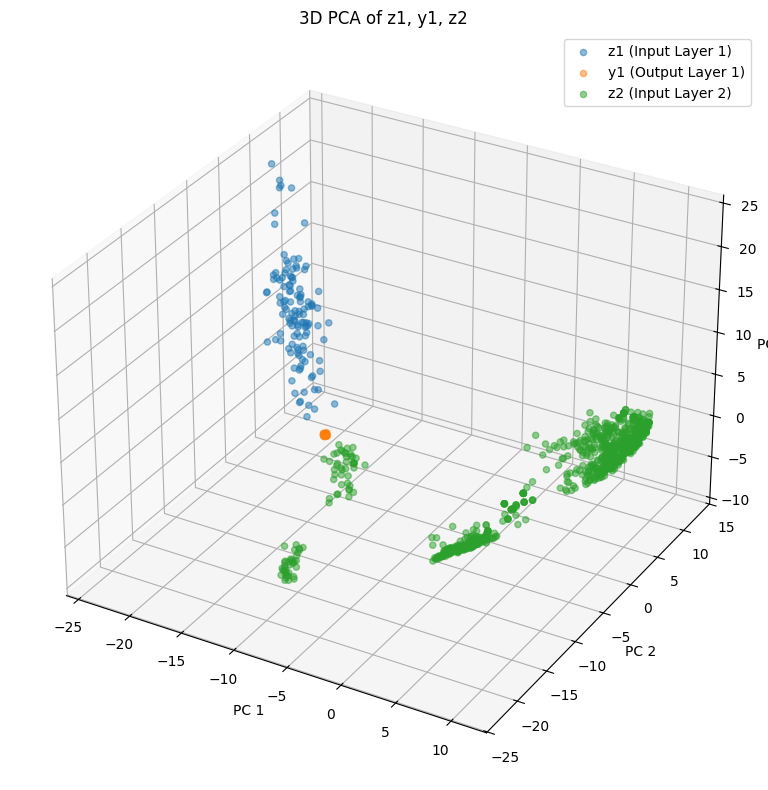

In [71]:
visualize_pca_distributions(a_yi, f1_out, z2)

In [34]:
def compute_mmd(x, y, kernel='rbf', sigma=1.0):
    """Computes the Maximum Mean Discrepancy (MMD) between x and y."""
    xx = torch.cdist(x, x, p=2)
    yy = torch.cdist(y, y, p=2)
    xy = torch.cdist(x, y, p=2)

    k_xx = torch.exp(-xx.pow(2) / (2 * sigma**2))
    k_yy = torch.exp(-yy.pow(2) / (2 * sigma**2))
    k_xy = torch.exp(-xy.pow(2) / (2 * sigma**2))

    mmd = k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    return mmd


In [65]:
def train_adapter_aligning_experts(y1, f1_output, f2, z2, lr=1e-3, steps=1000):
    adapter = Adapter(y1.size(-1)).to(y1.device).train()
    opt = torch.optim.Adam(adapter.parameters(), lr=lr)

    y1 = y1.to(torch.float32)
    f1_output = f1_output.to(torch.float32)
    f2 = f2.to(torch.float32)
    z2 = z2.to(torch.float32)
    lambda_mmd = 1
    # adapter = adapter.to(torch.float32)

    for _ in range(steps):

        aligned_input = adapter(y1)
      # with torch.no_grad(): # Wrap the call to f2 with no_grad
        f2_output = f2(aligned_input)
        # f2_output.to(torch.float32)
        # f2_output = f2(aligned_input

        # f2_output = f2(aligned_input)
        if torch.isnan(f2_output).any():
          print("❌ NaNs in f2_output")
          break
        if torch.isnan(f1_output).any():
            print("❌ NaNs in f1_output")
            break
        if f2_output.ndim == 3:
            f2_output = f2_output.view(-1, f2_output.size(-1))
        if f1_output.ndim == 3:
            f1_output = f1_output.view(-1, f1_output.size(-1))

        loss = F.mse_loss(f2_output, f1_output)
        loss_mmd = compute_mmd(aligned_input, z2)
        total_loss = loss + lambda_mmd * loss_mmd
        opt.zero_grad()
        total_loss.backward(retain_graph=True)
        opt.step()

    # print(loss.detach().item())

    f2 = f2.to(torch.float16)
    print(total_loss.item())
    return adapter, total_loss.item()

In [66]:
f2 = model.model.layers[layer2].mlp.experts[expert2]

In [67]:
adapter, loss = train_adapter_aligning_experts(z1, f1_out, f2, z2)

0.012425106950104237


In [68]:
adapter.to(torch.float16)

Adapter(
  (linear): Linear(in_features=2048, out_features=2048, bias=True)
  (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
)

In [69]:
a_yi = adapter(f1_out)

In [70]:
a_yi = a_yi.detach()

In [102]:
adapter_bank = {}  # store adapters by (layer, expert)

In [113]:
# Adapter-aligned Expert Swap + Finetuning Setup for WikiText
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, TextDataset, DataCollatorForLanguageModeling


class Adapter(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(self.linear(x))


# Inject adapter before a specific expert in layer
def inject_pre_expert_adapter(model, layer, expert):
    orig_expert = model.model.layers[layer].mlp.experts[expert]
    adapter = Adapter(orig_expert.down_proj.out_features).to(orig_expert.down_proj.weight.device)

    class WrappedExpert(nn.Module):
        def __init__(self, adapter, expert):
            super().__init__()
            self.adapter = adapter
            self.expert = expert

        def forward(self, x):
            return self.expert(self.adapter(x))

    wrapped = WrappedExpert(adapter, orig_expert)
    model.model.layers[layer].mlp.experts[expert] = wrapped
    adapter_bank[(layer, expert)] = adapter
    return adapter


# Swap experts between (l1, e1) and (l2, e2)
def swap_experts(model, l1, e1, l2, e2):
    temp = model.model.layers[l1].mlp.experts[e1]
    model.model.layers[l1].mlp.experts[e1] = model.model.layers[l2].mlp.experts[e2]
    model.model.layers[l2].mlp.experts[e2] = temp


# Freeze all weights except adapters
def freeze_all_except_adapters(model):
    for name, param in model.named_parameters():
        param.requires_grad = False
    for (l, e), adapter in adapter_bank.items():
        for param in adapter.parameters():
            param.requires_grad = True


# Load small WikiText chunk
def get_wikitext_dataset(tokenizer, path="wikitext-2-raw/wiki.test.raw", block_size=128):
    from datasets import load_dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=block_size)
    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
    return tokenized


# Train adapter on swapped model (language modeling loss)
def train_adapter_on_swapped_model(model, adapters, dataloader, steps=500, batch_size=4, lr=1e-4):
    model.train()
    freeze_all_except_adapters(model)
    optimizer = torch.optim.AdamW(adapters[(10, 30)].parameters(), lr=lr)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # device = next(model.parameters()).device

    for step, batch in enumerate(dataloader):
        if step >= steps:
            break
        input_ids = torch.stack(batch['input_ids']).to(model.device)
        # input_ids = batch['input_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = input_ids.clone().to(device)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 50 == 0:
            print(f"Step {step}: Loss = {loss.item():.4f}")

    print("\n✅ Finetuning complete.")


In [104]:

device = torch.device("cuda")
layer_i, expert_i = 1, 30
layer_k, expert_k = 10, 50
adapter_epochs = 2
adapter_lr = 1e-4
adapter_save_path = "/content/adapters_swap"


In [107]:
adapter_bank

{(10,
  30): Adapter(
   (linear): Linear(in_features=2048, out_features=2048, bias=True)
   (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
 ),
 (1,
  50): Adapter(
   (linear): Linear(in_features=2048, out_features=2048, bias=True)
   (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
 )}

In [106]:
# --- RUN ---
swap_experts(model, layer_i, expert_i, layer_k, expert_k)
adapter1 = inject_pre_expert_adapter(model, layer_k, expert_i)
adapter2 = inject_pre_expert_adapter(model, layer_i, expert_k)

# train_adapter_on_swapped_model(model, [adapter1, adapter2], train_loader, steps=adapter_epochs, lr=adapter_lr)

# # --- Save Adapters ---
# torch.save(adapter1.state_dict(), f"{adapter_save_path}/adapter_L{layer_k}E{expert_i}_swapped.pt")
# torch.save(adapter2.state_dict(), f"{adapter_save_path}/adapter_L{layer_i}E{expert_k}_swapped.pt")
# print("✅ Swap + Adapter Training Completed.")

In [114]:
train_adapter_on_swapped_model(model, adapter_bank, train_loader, steps=adapter_epochs, lr=adapter_lr)

# --- Save Adapters ---
torch.save(adapter1.state_dict(), f"{adapter_save_path}/adapter_L{layer_k}E{expert_i}_swapped.pt")
torch.save(adapter2.state_dict(), f"{adapter_save_path}/adapter_L{layer_i}E{expert_k}_swapped.pt")
print("✅ Swap + Adapter Training Completed.")

RuntimeError: Tensor on device meta is not on the expected device cuda:0!